# Space weather HMI Active Region Patches (SHARP) dataset

 [The Space Weather HMI Active Region Patches (SHARP) dataset](https://link.springer.com/article/10.1007/s11207-014-0529-3) is a collection of solar data captured by the Helioseismic and Magnetic Imager (HMI) on NASA's Solar Dynamics Observatory (SDO). This dataset provides high-resolution solar imagery and magnetic field data, focusing on active regions that are key in understanding and predicting solar flares and other space weather events. The SHARP dataset includes various parameters, such as magnetic field components, Doppler velocity, and continuum intensity, making it invaluable for space weather research.


For each identified active region patch, the SHARP dataset offers a comprehensive suite of imaging types, encompassing vector magnetic field images, Doppler velocity, continuum intensity, and line-of-sight magnetograms. These images are made available in two coordinate systems: CCD(helio-projective Cartesian) and CEA (Cylindrical Equal Area), catering to a variety of research needs and analysis approaches. The dataset also includes  16 magnetic summary parameters derived from the vector magnetic field maps. For each tracked active region,  the magnetograms and summary parameters are  provided at a 12-minute cadence.



In this notebook, we will be present magnetic summary parameters and image data taken by the Helioseismic and Magnetic Imager (HMI) instrument on NASA's Solar Dynamics Observatory (SDO) satellite. SDO takes about a terabyte and a half of data a day, which is more data than any other satellite in the NASA Heliophysics Division.

Data from the HMI instruments aboard SDO are stored at Stanford University. The metadata (keywords and magnetic summary parameters) are stored in a pSQL database called the Data Record Management System, or DRMS. The image data are stored separately, in storage units called the Storage Unit Management System, or SUMS. Data are merged together, upon export from both systems, as FITS files. DRMS and SUMS together constitute the Joint Science Operations Center, or JSOC.

The easiest way to access SDO HMI is via the python `drms` module, available at [PyPI](https://pypi.python.org/pypi/drms). First we'll import the module, and some others:

In [4]:
%pip install drms sunpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.1 MB/s eta 0:00:00


In [5]:
import drms
import json, numpy as np, matplotlib.pylab as plt, matplotlib.ticker as mtick
from datetime import datetime as dt_obj
import urllib
from astropy.io import fits
from sunpy.visualization.colormaps import color_tables as ct
from matplotlib.dates import *
import matplotlib.image as mpimg
import sunpy.map
import sunpy.io
from IPython.display import Image
%matplotlib inline
%config InlineBackend.figure_format='retina'

The first step in querying for SDO HMI  data is to establish a connection to JSOC. This can be done with the `Client()` class.

In [10]:
import drms
c = drms.Client()

The `Client()` class allows one to access both metadata and image data simultaneously via a data series. A data series contains all of particular type of data — e.g. there is a series for continuum intensity data, another for magnetic field data, and so forth. Read Section 4 of the [SDO Analysis Guide](https://www.lmsal.com/sdodocs/doc/dcur/SDOD0060.zip/zip/entry/) for more information about how to build a data series query. For example, to find all the SHARP data series, execute the following regular expression query:

In [11]:
c.series(r'hmi\.sharp_')

['hmi.sharp_720s',
 'hmi.sharp_720s_dconS',
 'hmi.sharp_720s_nrt',
 'hmi.sharp_cea_720s',
 'hmi.sharp_cea_720s_dconS',
 'hmi.sharp_cea_720s_nrt']

In [12]:
# Set a series
si = c.info('hmi.sharp_cea_720s')

To find more information about the FITS header keywords/summary parameters that belong to any given series, we can use the following command:

In [13]:
si.keywords

,type,recscope,defval,units,note,linkinfo,is_time,is_integer,is_real,is_numeric
name,,,,,,,,,,
cparms_sg000,string,variable,compress Rice,none,,None,False,False,False,False
magnetogram_bzero,double,variable,0,none,,None,False,False,True,True
magnetogram_bscale,double,variable,0.1,none,,None,False,False,True,True
cparms_sg001,string,variable,,none,,None,False,False,False,False
bitmap_bzero,double,variable,0,none,,None,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...
ERRMSHA,float,variable,nan,Degrees,Error in Mean shear angle for B_total,None,False,False,True,True
ERRUSI,float,variable,nan,Amperes,Error in Total unsigned vertical current,None,False,False,True,True
DOFFSET,int,variable,-2147483648,Gauss,Constant value added to the noise mask for dis...,None,False,True,False,True


To find more information about the FITS image data, or segments, that belong to any given series, we can use the following command:

In [14]:
# To see all the segments associated with the series hmi.sharp_cea_720s:
si.segments

,type,units,protocol,dims,note
name,,,,,
magnetogram,int,Gauss,fits,VARxVAR,Line-of-sight magnetogram in CEA projection
bitmap,char,Enumerated,fits,VARxVAR,Mask for the patch in CEA coordinates
Dopplergram,int,m/s,fits,VARxVAR,Dopplergram in CEA projection
continuum,int,DN/s,fits,VARxVAR,Intensitygram in CEA projection
Bp,int,Gauss,fits,VARxVAR,"B_phi, positive westward"
Bt,int,Gauss,fits,VARxVAR,"B_theta, positive southward"
Br,int,Gauss,fits,VARxVAR,"B_r, positive up"
Bp_err,int,Gauss,fits,VARxVAR,Standard deviation of B_phi
Bt_err,int,Gauss,fits,VARxVAR,Standard deviation of B_theta


## Plotting the metadata

The query below retrieves both metadata and image data for active region 11158, which produced an X2.2-class flare on February 15, 2011 at 1:56 UT, from the SHARP data series. The [SHARP data series](https://link.springer.com/article/10.1007%2Fs11207-014-0529-3) include patches of vector magnetic field data taken by the HMI instrument. These patches encapsulate automatically-detected active regions that are tracked throughout the entirety of their disk passage. The `c.query()` method takes three arguments:
1. The first argument is the data series. In the example below, the data series is called `hmi.sharp_cea_720s`. This series is appended with two prime keys: the HARP number (in this case, 377) and the time range (in this case, 2011.02.14_15:00:00/12h). These two prime keys appear in the first two brackets. The HARP number refers to the active region number (see [here](http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt) for a mapping between HARP numbers and NOAA active region numbers). A prime key, or set of prime keys, is a unique identifier. The third bracket, with the argument `[? (QUALITY<65536) ?]`, filters out data where the value of the `QUALITY` keyword is greater than 65536. (See [here](http://jsoc.stanford.edu/doc/data/hmi/Quality_Bits/QUALITY.txt) for the definition of the `QUALITY` keyword). While this third bracket is not necessary, it can be a powerful tool for filtering data based on keyword values.
2. The second argument in the search query is a list of keywords. In this example, we will query for the keywords `T_REC`, `USFLUX`, and `ERRVF`.
3. The third argument in the search query is a list of segments. In this example, we will query for the segment `Br`, or the radial component of the photospheric magnetic field.

In [15]:
keys, segments = c.query('hmi.sharp_cea_720s[377][2011.02.14_15:00:00/12h][? (QUALITY<65536) ?]', key='T_REC, USFLUX, ERRVF', seg='Br')

To convert the keyword `T_REC` into a datetime object, we can use the function below.

In [16]:
def parse_tai_string(tstr,datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime: return dt_obj(year,month,day,hour,minute)
    else: return year,month,day,hour,minute

In [17]:
t_rec = np.array([parse_tai_string(keys.T_REC[i],datetime=True) for i in range(keys.T_REC.size)])

Now for some plotting! matplotlib.pyplot generates two objects: a figure and axes. The data are ascribed to the axes. The time axes in particular requires some formatting; in order to free it of clutter, we'll plot tick marks every three hours and label them accordingly.

Text(0.5, 1.0, 'total unsigned flux starting at 2011-02-14 15:00:00 UT')

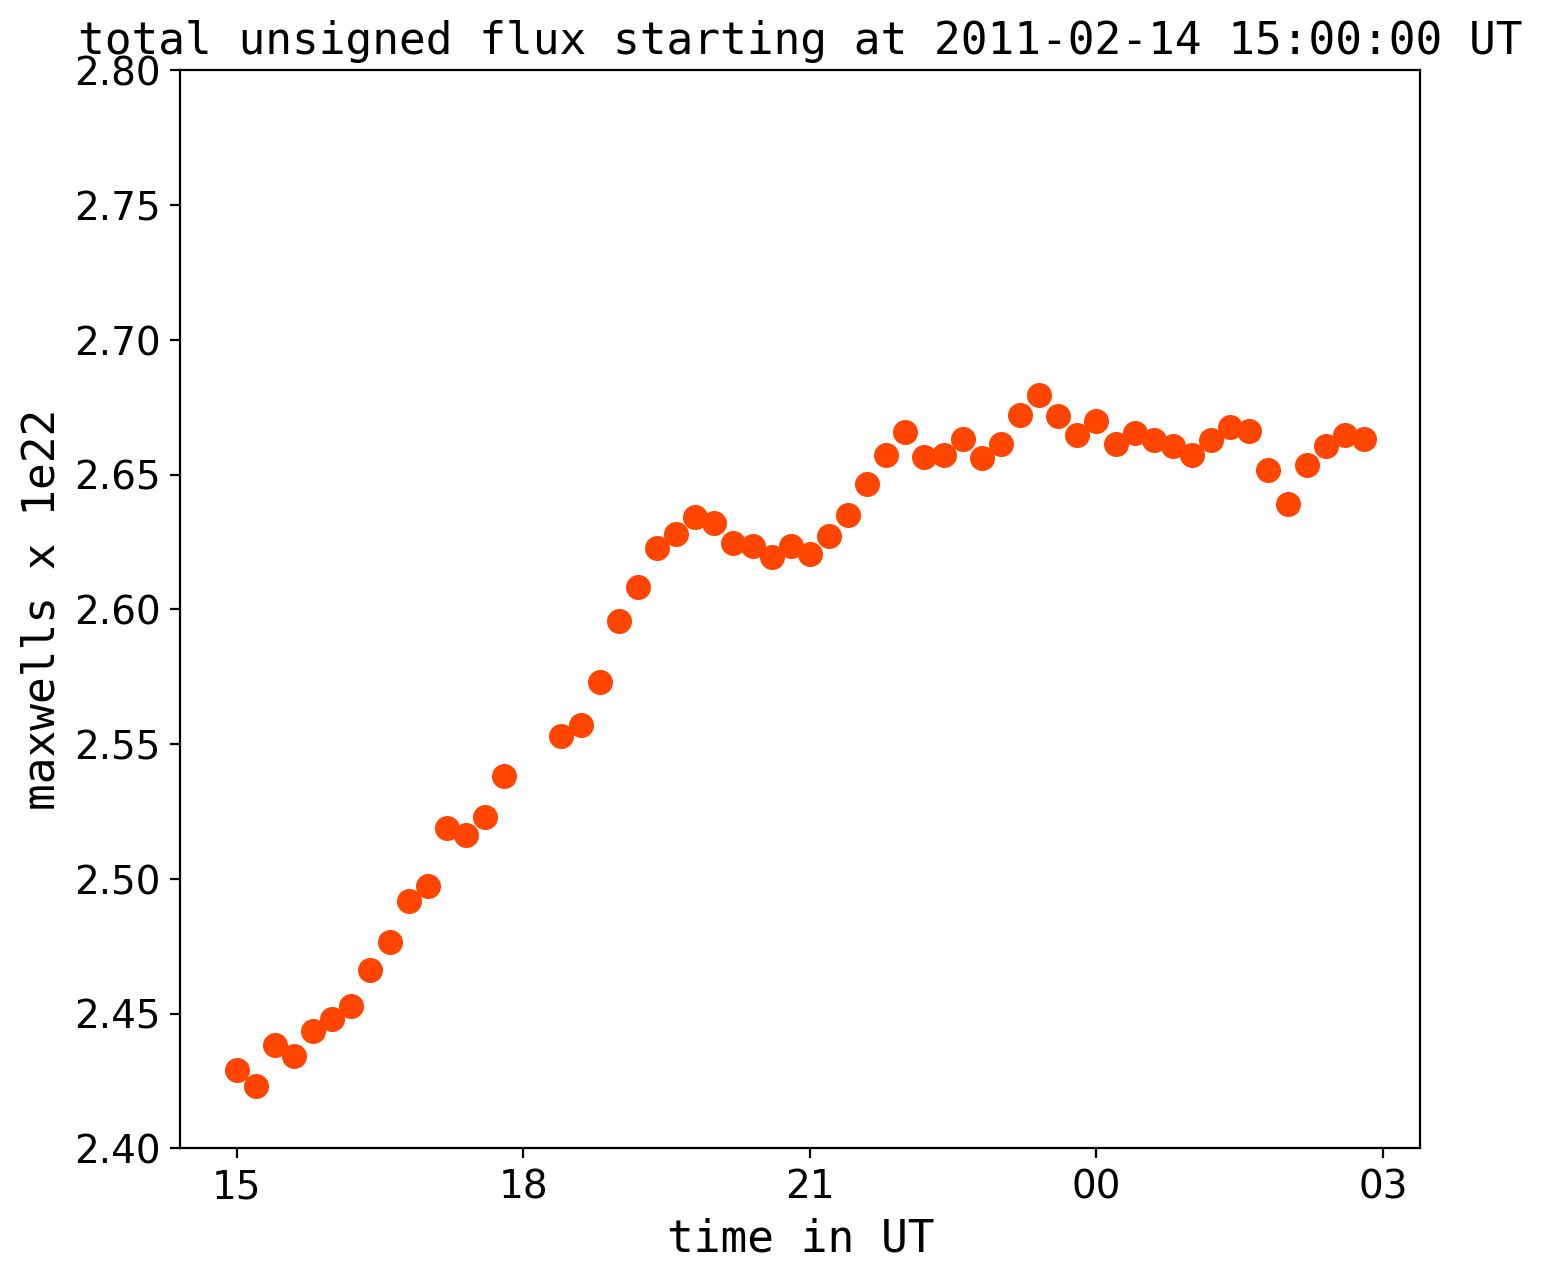

In [18]:
fig, ax = plt.subplots(figsize=(8,7))      # define the size of the figure
orangered = (1.0,0.27,0,1.0)                # create an orange-red color

# define some style elements
marker_style = dict(linestyle='', markersize=8, fillstyle='full',color=orangered,markeredgecolor=orangered)
text_style = dict(fontsize=16, fontdict={'family': 'monospace'})
ax.tick_params(labelsize=14)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

# ascribe the data to the axes
ax.plot(t_rec, (keys.USFLUX)/(1e22),'o',**marker_style)
ax.errorbar(t_rec, (keys.USFLUX)/(1e22), yerr=(keys.ERRVF)/(1e22), linestyle='',color=orangered)

# format the x-axis with universal time
locator = AutoDateLocator()
locator.intervald[HOURLY] = [3] # only show every 3 hours
formatter = DateFormatter('%H')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# set yrange
ax.set_ylim([2.4,2.8])

# label the axes and the plot
ax.set_xlabel('time in UT',**text_style)
ax.set_ylabel('maxwells x 1e22',**text_style)
ax.set_title('total unsigned flux starting at '+str(t_rec[0])+' UT',**text_style) # annotate the plot with a start time

## Plotting the line-of-sight magnetograms

We can also query for and plot image data.

We can download the line-of-sight magnetograms, as unmerged FITS file, and header data separately. An unmerged FITS file contains the image data, but almost no header metadata (except for a few keywords). This is the quickest and easiest option as the `drms.Client()` class can query the header and image data at the same time and store the keyword metadata and URLs to the image data in a Pandas dataframe. This eliminates the need to store FITS files locally. This method is also faster, as there is no need to wait for the exportdata system to generate FITS files. We can then download and open the unmerged FITS files via the [`astropy` package for FITS file handling](https://docs.astropy.org/en/stable/io/fits/index.html).



Query the image data and header metadata using `drms`, then download and open the unmerged FITS file with `astropy`:

In [30]:
hmi_query_string = 'hmi.sharp_cea_720s[377][2011.02.15_02:12:00_TAI]'
keys, segments = c.query(hmi_query_string, key='T_REC, USFLUX, ERRVF', seg='magnetogram')
url = 'http://jsoc.stanford.edu' + segments.magnetogram[0]   # add the jsoc.stanford.edu suffix to the segment name
photosphere_image = fits.open(url)                  # download and open the unmerged FITS file via astropy

Plot the image data with `matplotlib`:

The dimensions of this image are 377 by 744 .


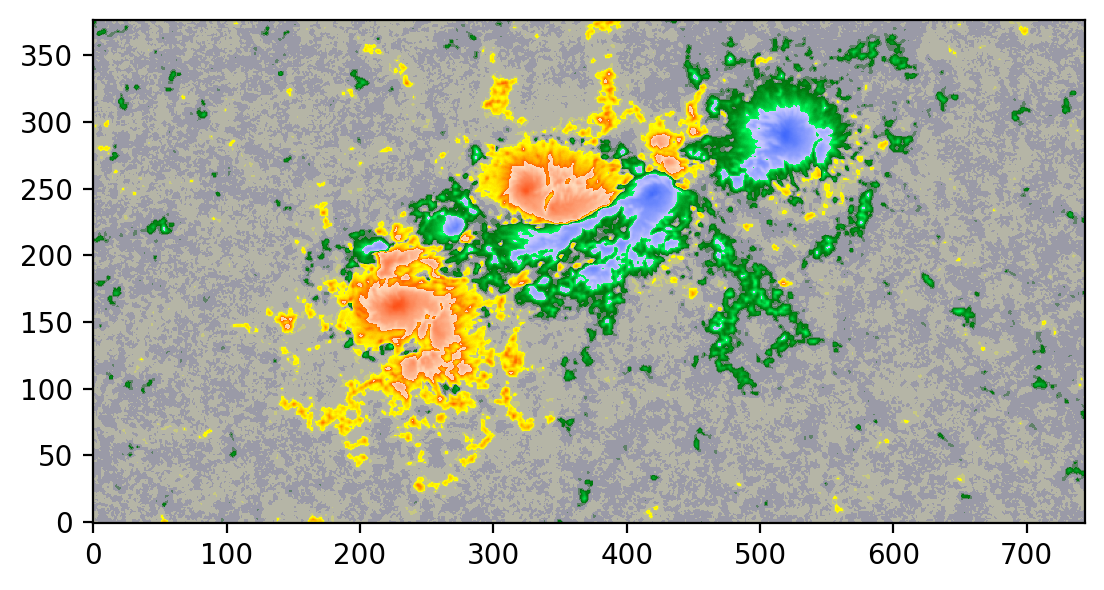

In [31]:
hmimag = plt.get_cmap('hmimag')
plt.imshow(photosphere_image[1].data,cmap=hmimag,origin='lower',vmin=-3000,vmax=3000)
print('The dimensions of this image are',photosphere_image[1].data.shape[0],'by',photosphere_image[1].data.shape[1],'.')

There are only a few keywords associated with the unmerged FITS file:

In [25]:
photosphere_image[1].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -64 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                  744 / length of original image axis                  
NAXIS2  =                  377 / length of original image axis                  
BLANK   =          -2147483648                                                  
CHECKSUM= '9XaaDXTT9XZYCXZY'   / HDU checksum updated 2018-05-10T01:45:49       
DATASUM = '602510891'          / data unit checksum updated 2018-05-10T01:45:49 
                                                                                
                                                                                

But we can get all the header metadata information we like from the `drms` query:

In [21]:
keys

,T_REC,USFLUX,ERRVF
0,2011.02.15_02:12:00_TAI,2.653720e+22,6.506040e+18
